In [1]:
import pden
import pden.Net
import pden.Operations
import pden.PDENet

import tensorflow as tf

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from IPython.display import clear_output

%load_ext autoreload
%autoreload 1

%aimport pden.Net
%aimport pden.Operations
%aimport pden.PDENet

In [2]:
def der(y, x, y_shape: int, x_shape: int):
    ys = tf.split(y, [1] * y_shape, 1)
    def _der(i, j=[]):
        f = ys[i]
        for _j in j:
            fs = tf.gradients(f, x)[0]
            f  = tf.split(fs, [1] * x_shape, 1)[_j]        
        return f
    return _der

In [3]:
N = 7

pnet = pden.PDENet.FourierNet1D(fourier_terms=N, training_epochs=501, learning_rate=5e-3)

print(pnet.net_cos)
print(pnet.net_sin)

Net 4:
	25	Linear: [1 -> 7]
	2	Activation funciton: <function cos at 0x111a63830>
	3	Linear: [7 -> 1]
Net 14:
	30	Linear: [1 -> 7]
	27	Activation funciton: <function sin at 0x111a9c440>
	6	Linear: [7 -> 1]


In [313]:
init_x = tf.placeholder(tf.float64, [1, 1])
init_y = pnet.forward(init_x)

bc_x = tf.placeholder(tf.float64, [1, 1])
bc_y = pnet.forward(bc_x)

x = tf.placeholder(tf.float64, [None, 1])
y = pnet.forward(x)

der_gen = der(y, x, 1, 1)
dy = der_gen(0, j=[0])

In [314]:
pnet = pnet.add_loss(tf.reduce_mean(tf.pow(tf.pow(dy, 2) * y - tf.pow(2 * x, 2) * tf.pow(x, 2), 2)))
pnet = pnet.add_loss(tf.reduce_mean(tf.pow(bc_y - 1.0, 2)), weight=15.0)
pnet = pnet.add_loss(tf.reduce_mean(tf.pow(init_y - 0.0, 2)), weight=15.0)

Training progress: 100%|██████████| 501/501 [00:01<00:00, 336.83it/s]


Training finished in: 	1.8506179999999972
	After 501, loss is 0.0016253996974574868
Optimization Finished!


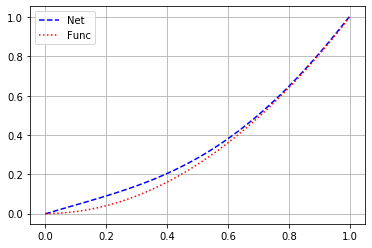

In [319]:
X = np.linspace(0, 1, 100).reshape(-1, 1)

feed_dict={
    x: X,
    init_x: np.array([[0.0]]),
    bc_x: np.array([[1.0]])
}

Y = pnet.train(feed_dict)

print("Optimization Finished!")

plt.plot(X.flatten(), Y.flatten(), '--b', label='Net')
plt.plot(X.flatten(), X.flatten() ** 2, ':r', label='Func')
plt.legend()
plt.grid()
plt.show()